# Восстановление изображений (Автоэнкодер и MNIST)

## Импорт библиотек

In [17]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Загрузка данных

In [18]:
transformations = transforms.Compose([
  transforms.ToTensor()
])

batch_size = 64

train_dataset = MNIST(
    root="./",
    train=True,
    transform=transformations,
    download=True
)

test_dataset = MNIST(
    root="./",
    train=False,
    transform=transformations,
    download=True
)

### DataLoader-ы

In [19]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=os.cpu_count(),
    drop_last=True
    )

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=os.cpu_count(),
    drop_last=True
    )

## Автоэнкодер

### Класс SimpleAutoEncoder

In [20]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, feature_size=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(inplace=True)
        )

        self.encoder_fc = nn.Linear(14*14*64, feature_size)
        self.decoder_fc = nn.Linear(feature_size, 14*14*64)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.LeakyReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 3, 1, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, 1)
        x = self.encoder_fc(x)
        return x

    def decode(self, x):
        x = self.decoder_fc(x)
        x = x.view(-1, 64, 14, 14)
        x = self.decoder(x)
        return x

    def forward(self, x):
        z = self.encode(x)
        x_pred = self.decode(z)
        return x_pred

## Обучение модели

In [21]:
feature_size = 2
lr = 0.0005
nrof_epochs = 30
loss_fn_name = "rmse"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model = SimpleAutoEncoder(feature_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

loss_fn = {
    "mse": nn.MSELoss(),
    "rmse": nn.MSELoss(),
    "cross-entropy": nn.CrossEntropyLoss()
}[loss_fn_name]

min_loss = 10e6

In [23]:
from torchsummary import summary


summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         LeakyReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         LeakyReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          36,928
         LeakyReLU-6           [-1, 64, 14, 14]               0
            Linear-7                    [-1, 2]          25,090
            Linear-8                [-1, 12544]          37,632
   ConvTranspose2d-9           [-1, 64, 14, 14]          36,928
        LeakyReLU-10           [-1, 64, 14, 14]               0
  ConvTranspose2d-11           [-1, 32, 28, 28]          18,464
        LeakyReLU-12           [-1, 32, 28, 28]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]             289
          Sigmoid-14            [-1, 1,

In [24]:
train_losses = []
val_losses = []
REP_FREQ = 10

model.train()
for epoch in range(nrof_epochs):
    train_loss = 0.0
    for i_batch, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.to(device)
        x_pred = model(x)

        loss_batch = loss_fn(x_pred, x)
        if loss_fn_name == "rmse":
            loss_batch = torch.sqrt(loss_batch)
        loss_batch.backward()
        optimizer.step()

        train_loss += loss_batch.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Валидация модели
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i_batch, (x_val, _) in enumerate(test_loader):
            x_val = x_val.to(device)
            x_val_pred = model(x_val)
            val_loss_batch = loss_fn(x_val_pred, x_val)
            if loss_fn_name == "rmse":
                val_loss_batch = torch.sqrt(val_loss_batch)
            val_loss += val_loss_batch.item()

        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        if epoch % REP_FREQ == 0:
            print(f"Epoch {epoch}/{nrof_epochs} | Train Loss: {train_loss}")
            print(f"Epoch {epoch}/{nrof_epochs} | Validation Loss: {val_loss}")

    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), "./model.pt")

Epoch 0/30 | Train Loss: 0.23394161688607173
Epoch 0/30 | Validation Loss: 0.22087024371975508
Epoch 10/30 | Train Loss: 0.20210946334591542
Epoch 10/30 | Validation Loss: 0.20277552717389205
Epoch 20/30 | Train Loss: 0.1986989398171833
Epoch 20/30 | Validation Loss: 0.20151413069703641


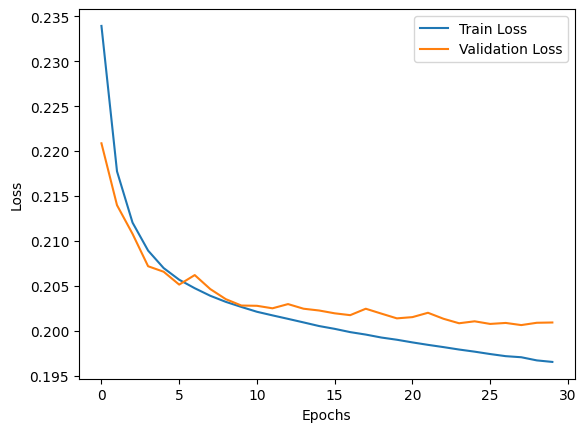

In [25]:
# Визуализация динамики потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Валидация модели

In [26]:
model.eval()
loss = 0.
for i_batch, (x, _) in enumerate(test_loader):
    x = x.to(device)
    x_pred = model(x)

    loss_batch = loss_fn(x_pred, x)
    if loss_fn_name == "rmse":
        loss_batch = torch.sqrt(loss_batch)
    loss += loss_batch

loss = loss / (i_batch + 1)
print(f"Test set lost: {loss.item()}")

Test set lost: 0.20091615617275238


In [27]:
def rescale(x):
    x = x - np.min(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
    x = x / np.max(x, (1, 2, 3)).reshape(-1, 1, 1, 1)
    return (x*255).astype(np.uint8)


def torch_to_numpy(x):
    x = x.detach().cpu().numpy()
    x = x.transpose(0, 2, 3, 1)
    x = rescale(x)
    return x


def make_samples_grid(x, x_pred=None, grid_shape=6*6):
    x = torch_to_numpy(x)
    if x_pred is not None:
        x_pred = torch_to_numpy(x_pred)

    n = 2 if x_pred is not None else 1

    H, W = x.shape[1:3]
    m = int(np.sqrt(grid_shape))
    grid = np.zeros((H*m, W*m), dtype=np.uint8)

    i = 0
    for row in range(m):
        for col in range(m):
            sample = [x, x_pred][i%n]
            grid[H*row:H*(row+1), W*col:W*(col+1)] = sample[int(i//n)][..., 0]
            i += 1
    return grid

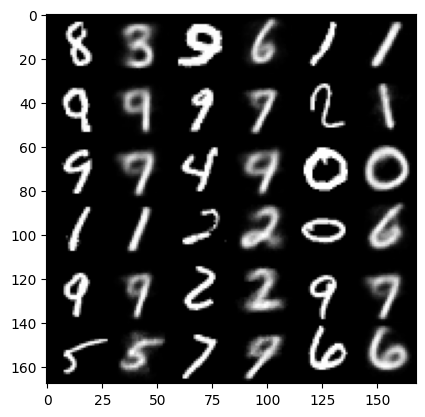

In [28]:
# Реконструкция нескольких изображений из тестового датасета
indices = np.arange(len(test_dataset))
np.random.shuffle(indices)

x = []
y = []
for index in indices:
    image, label = test_dataset[index]
    x.append(image)
    y.append(label)

x = torch.stack(x)
x = x.to(device)
x_pred = model(x)

grid = make_samples_grid(x, x_pred)
plt.imshow(grid, cmap="gray")
plt.show()

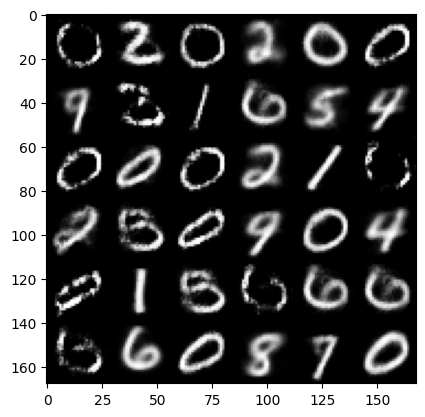

In [29]:
# Генерация сэмплов из шума
random = np.sqrt(10)*torch.randn((36, 2))
random = random.to(device)
random_samples = model.decode(random)

grid = make_samples_grid(random_samples)
plt.imshow(grid, cmap="gray")
plt.show()